<a href="https://colab.research.google.com/github/yunju-1118/ESAA/blob/main/ESAA_YB_week11_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **필사: [Subinium Tutorial] House Prices (Advanced)**

https://www.kaggle.com/code/subinium/subinium-tutorial-house-prices-advanced

#### **특성 공학**
- Inputing missing values
- Transforming: 수치형 -> 범주형
- Label Encoding: 범주형 -> 서수형
- Box Cox Transformation: 비대칭 분포 데이터에 대해 더 좋은 성능을 보임
- Getting dummy variables: 범주형 특성

#### **알고리즘**
- sklearn based model
- DMLS's XGBoost
- Microsoft's LightGBM

## **library, data 확인하기**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# sns Theme
sns.set_style('darkgrid')

# 소수점 표현 제한
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [4]:
# 데이터 읽기
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
# 데이터 체크
print(train_df.shape, test_df.shape)
train_df.head(5)

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


target을 제외하고 80개의 특성을 가지고 있으며, 그 외에는 데이터 분석과 관련 없는 ID 특성도 있다.

In [6]:
# Save the 'ID' column
train_ID = train_df['Id']
test_ID = test_df['Id']

# Now drop the  'Id' colum since it's unnecessary for the prediction process
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

## **Data Processing**

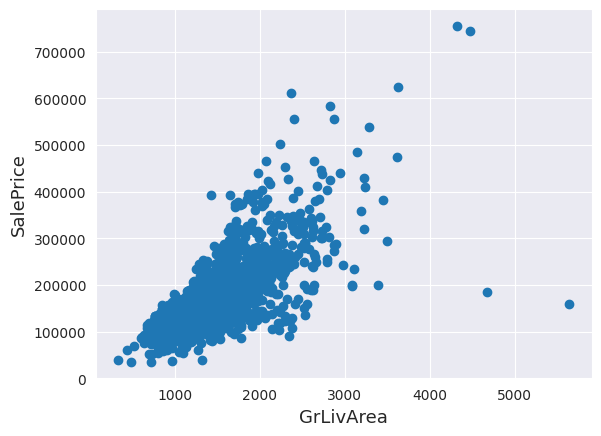

In [7]:
fig, ax = plt.subplots()

ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

해당 그래프를 보면 낮은 SalePrice에서 outlier로 보이는 2개의 데이터를 확인할 수 있다. 더 나은 성능을 위해 해당 두 개의 데이터를 삭제한다.

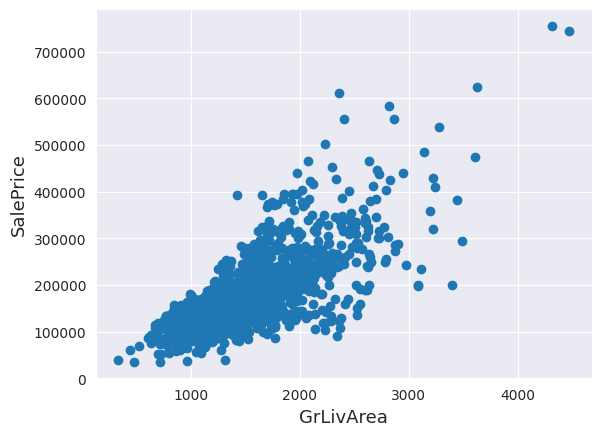

In [8]:
# Deleting outlier
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

# Check the Graph again
fig, ax = plt.subplots()
ax.scatter(train_df['GrLivArea'], train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

이상치 제거는 성능에 있어서 매우 중요하다.
이상치를 일일히 찾아 제거하지 않는 이유는 다음과 같다.
1. 훈련 데이터에 이상치가 많을 수 있지만, 테스트 데이터에도 이상치가 있을 수 있다.
2. 그렇다면 모델에 더 안 좋은 영향을 미칠 수 있다.

### Target Variable
SalePrice는 우리가 예측해야 하는 타겟으로 타겟 데이터에 대해 분석해보자.

다음 그래프를 이해하기 위해서는 다음과 같은 선지식이 필요하다.
- Q-Q Plot: 간단하게 두 데이터 집단 간의 분포를 확인

180932.91906721535 79467.78892987774


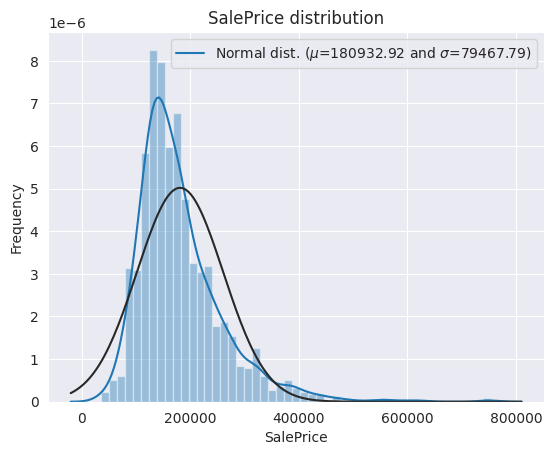

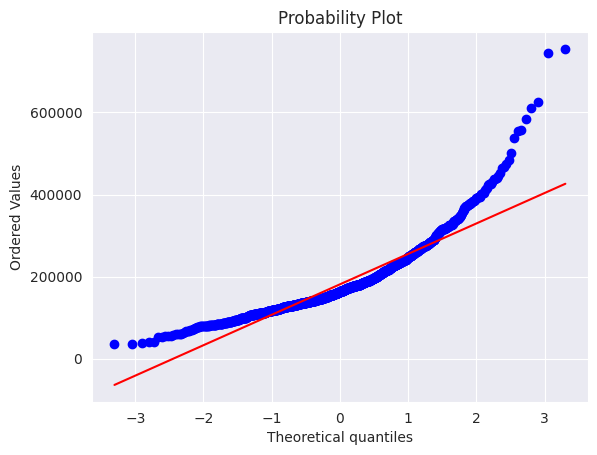

In [9]:
sns.distplot(train_df['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)

# plot
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

분포가 오른쪽으로 치우쳐져 있다. 회귀의 경우 target이 정규분포 형태일 때 유리하기 때문에 log화를 진행한다.

### Log-transformation of the target variable
- 데이터의 정규화를 위해 numpy의 log1p (모든 column의 원소에 $log(1+x)$) 함수를 사용해 데이터를 처리

12.024015155682552 0.3995757283645756


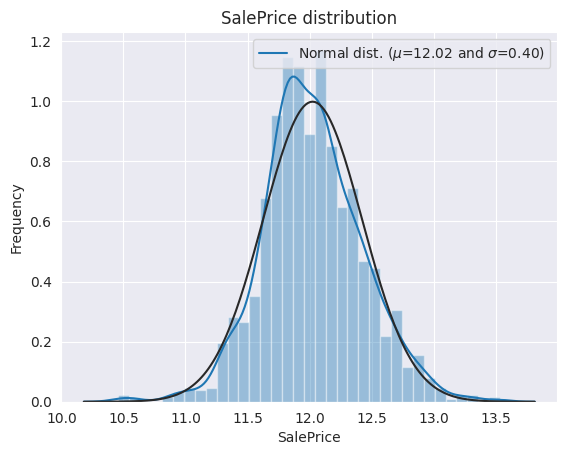

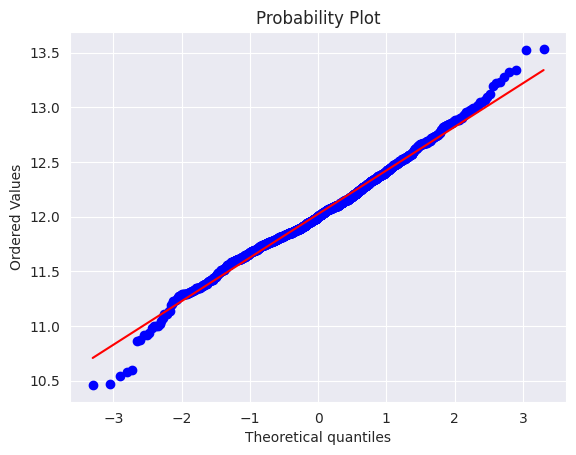

In [10]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# 위에서와 같은 코드로 분포 확인
sns.distplot(train_df['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

정규분포에 근사한 모양의 분포가 되었음을 알 수 있다.

## **Feature Engineering**


In [11]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y_train = train_df.SalePrice.values

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


### Missing values

In [12]:
all_data_na = (all_data.isnull().sum() / len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({"Missing Ratio": all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
MasVnrType,60.542
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageYrBlt,5.451
GarageCond,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

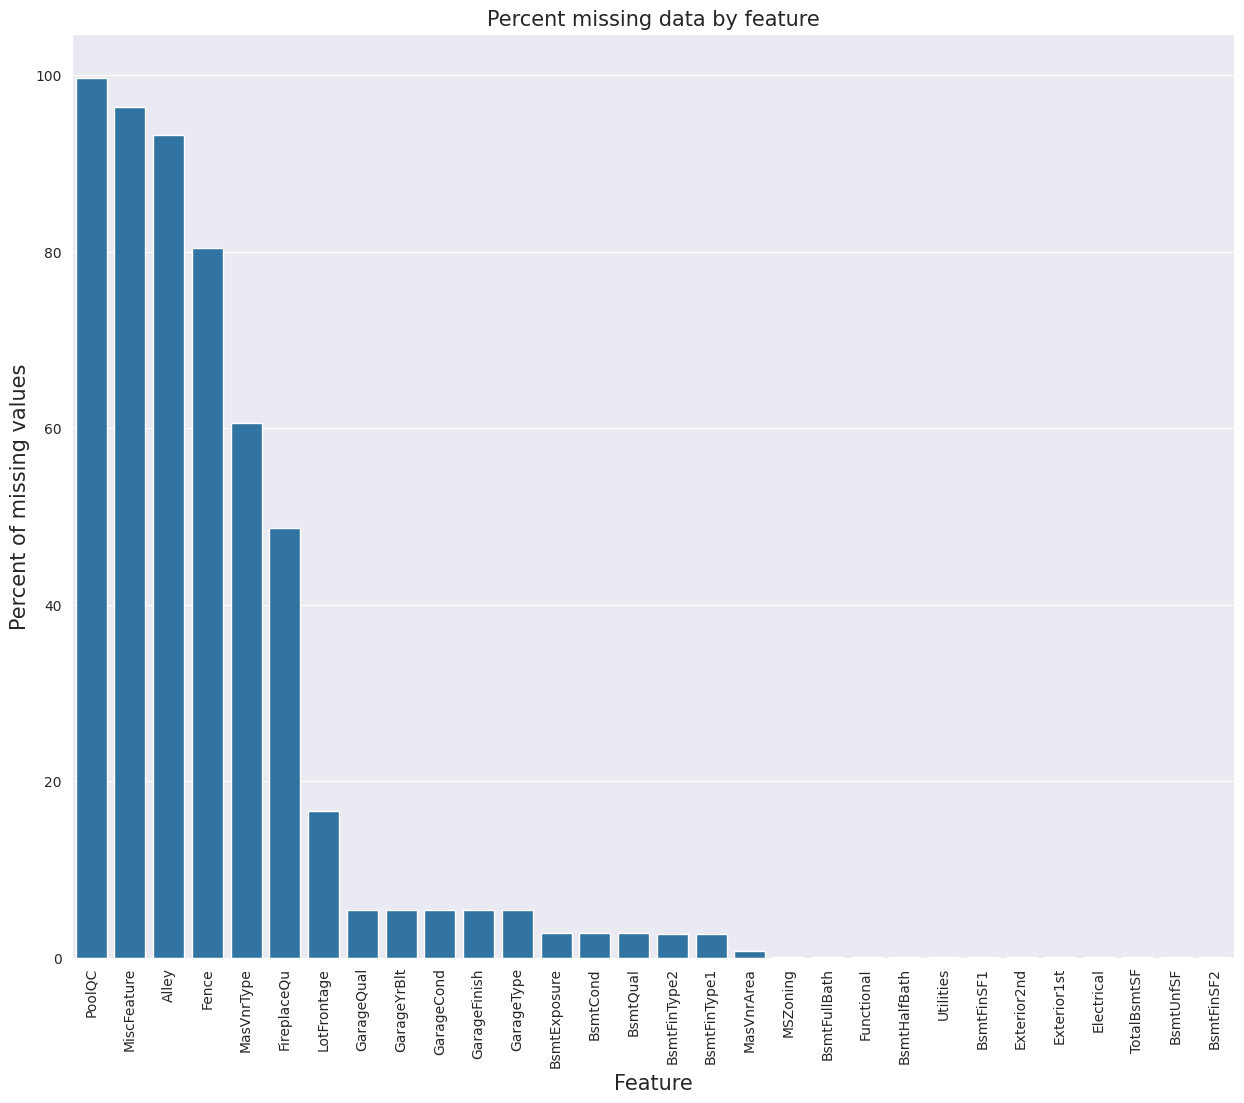

In [13]:
# Visualize
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

### Data Correlation
heatmap을 이용해 각 요소의 상관관계를 시각화해 더 직관적으로 볼 수 있다. 여기서 초점으로 봐야하는 요소는 SalePrice와 다른 요소 간의 상관관계이다.

<Axes: >

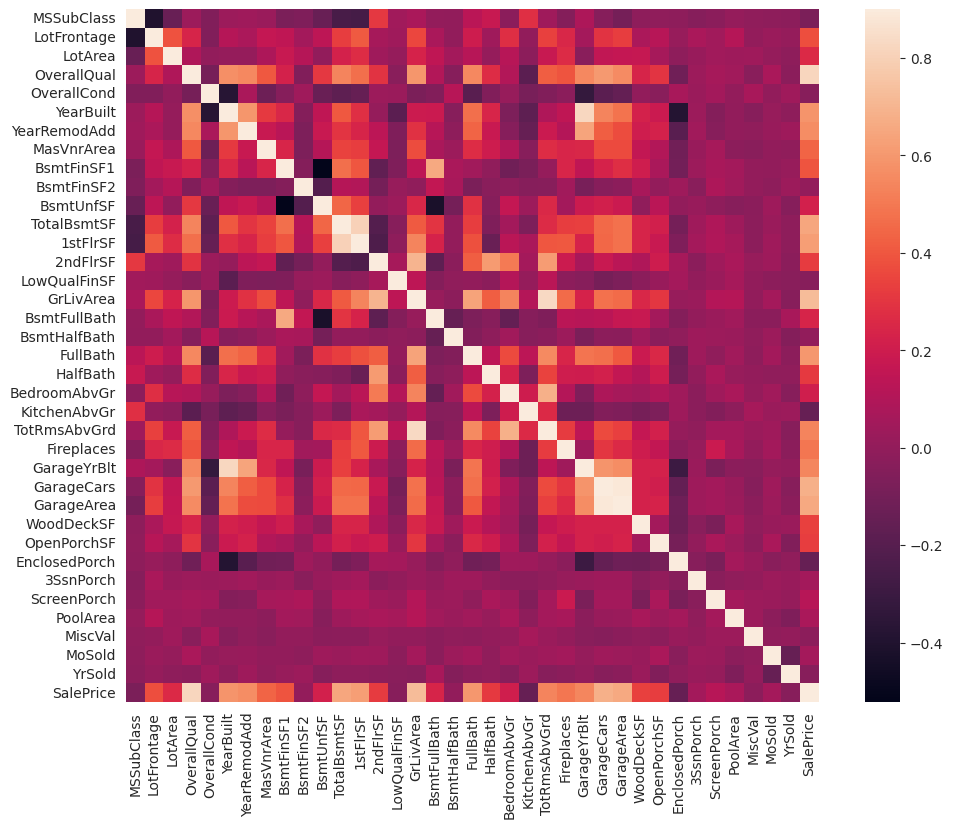

In [14]:
corrmat = train_df.select_dtypes(include=['number']).corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

### Input missing values
- PoolQC: NA값은 "No Pool"을 의미. 99%의 값을 채워줌


In [15]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- MiscFeature: NA는 "No misc feature", 이 외에도 Alley, Fence, FireplaceQu도 비슷함.

In [16]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- LotFrontage: 거리와 집의 거리 요소로 이 값들은 이웃들의 거리와 유사한 값을 가질 것임. 따라서, missing value는 이웃들의 중앙값으로 넣는다.

In [17]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x : x.fillna(x.median()))

- GragageType, GarageFinish, GarageQual and GarageCond: 이 부분도 None로 처리

In [18]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
  all_data[col] = all_data[col].fillna('None')

In [19]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [20]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [21]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [22]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- MSZoning: RL이 최빈값으로 빈 부분은 RL로 채운다.

In [23]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- Utilities: 이 데이터는 모든 값이 "AllPub", 한 개가 "NoSeWa", 그리고 2개가 NA값이므로 유용하지 않을 것 같아 drop 한다.

In [24]:
all_data = all_data.drop(['Utilities'], axis=1)

- Functional: NA는 typical을 의미

In [25]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- Electrical, KitchenQual, Exterior1st and Exterior2nd, SaleType : 최빈값으로 채움

In [26]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [27]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [28]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [29]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [30]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [31]:
#Check remaining missing values if any
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### More features engineering

수치형 값들 중 범주형인 특성들을 변환한다.

In [32]:
# MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].apply(str)

# Year and Month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [33]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


### Adding one more important feature
주택 가격에서 중요한 요소 중 하나는 집의 가용 평수이다. 따라서, 이런 특성을 basement + 1층 + 2층 공간으로 새로운 feature를 만든다.

In [34]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### Skewed Feature

In [35]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 수치형 데이터에서 skewness 체크
skewed_feats = all_data[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


### Box Cox Transformation of (highly) skewed features

In [36]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


### Getting dummy categorical features

In [37]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

(2917, 220)


## **Modeling**

### Import Libraries

In [38]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

### Define a cross validation strategy
검증의 정도를 높이기 위해 K-fold를 사용해 검증의 정확도를 높인다.

In [39]:
# Validation function
n_folds = 5

def rmsle_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.values)
  rmse = np.sqrt(-cross_val_score(model, train_df.values, y_train,
                                  scoring="neg_mean_squared_error", cv=kf))
  return (rmse)

### Base models
- **Lasso Regression**: 이상치에 매우 민감하기에 pipeline에 RobustScaler( ) 메서드를 이용한다.
- **ElasticNet Regression**: 이상치를 위해 같은 방법을 이용한다.

In [40]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **kernel Ridge Regression**

In [41]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression**: huber 손실 함수로 이상치를 관리한다. 이 손실함수는 다른 손실함수에 비해 이상치에 민감하지 않다.

In [42]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

- **XGBoost**: 하이퍼 파라미터 설정은 bayesian optimization을 사용한다.

In [43]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

- **LightGBM**

In [44]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Base models scores

In [45]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [46]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [47]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [48]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0083)



In [49]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1162 (0.0078)



In [50]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

## **Stacking models**
### Simplest Stacking approach: Averaging base models
우선 모델들의 성능을 평균하여 사용한다. class를 만들어 캡슐화하고 코드를 재사용할 수 있게 만든다.

In [51]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

### Averaged base models score
이제 **ENet, GBoost, KRR and Lasso**를 이용해 score를 낸다.

In [52]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.1087 (0.0077)



## Less simple Stacking: Adding a Meta-model

이 방법은 meta model을 추가하고, base model들의 평균과 이 out-of-folds 예측을 이용해 meta model을 훈련시킨다.

기본적인 흐름은 다음과 같다.
1. 훈련 데이터를 train, holdout 데이터셋으로 나눈다.
2. train 데이터로 훈련을 한다.
3. holdout 데이터로 테스트 한다.
4. 3번 방법을 통해 예측값을 구하고, meta model을 통해 예측값으로 모델을 학습한다.

첫 세 단계는 순서대로 진행하면 된다. k번의 반복이 끝나면 out-of-folds 예측값을 가지게 되고, 이제 이 값들을 이용해 meta model의 입력으로 사용한다.

예측에 있어서 테스트 데이터의 모든 모델의 예측값을 평균내고 이를 meta-features로 사용해 meta model로 마지막 예측값을 만든다.

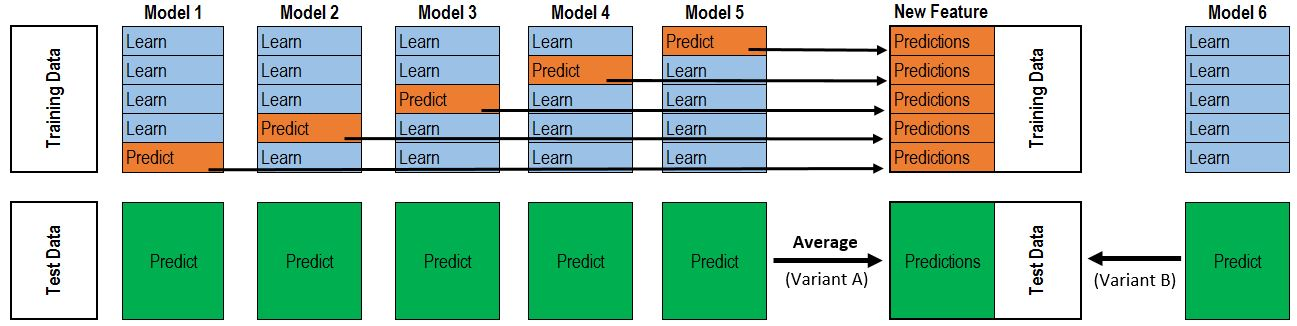

### Stacking averaged Models Class
다음과 같은 pseudo 코드를 구현했다.

베이스 모델의 예측값을 하나의 특성으로 사용해 최종 분류를 만든다고 이해하는 것이 가장 좋다.

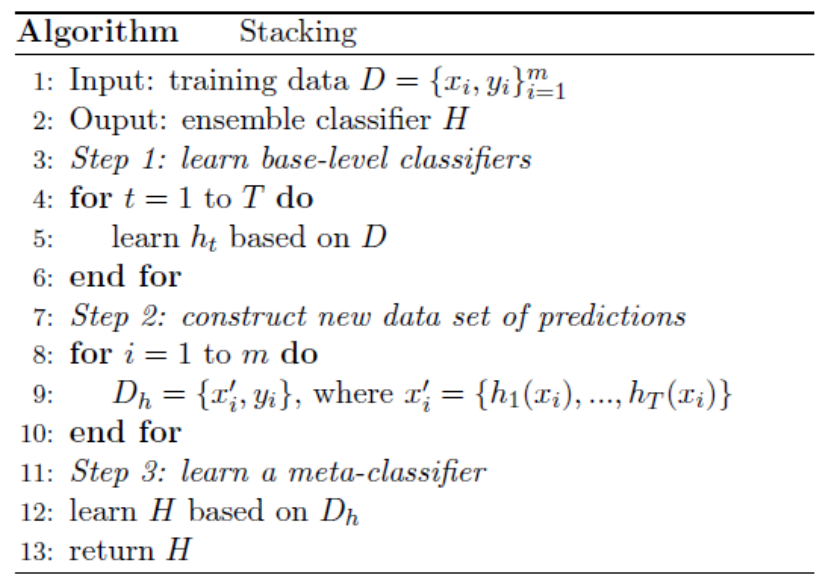

In [55]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # base_models_는 2차원 배열입니다.
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # 각 모델들의 평균값을 사용합니다.
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

### Stacking Averaged models Score
성능 비교를 위해 같은 모델을 이용해 score를 만들어보자.

In [56]:
stacked_averaged_models = StackingAveragedModels(
    base_models = (ENet, GBoost, KRR),
    meta_model = (lasso)
)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


meta learner를 이용해 더 나은 점수를 받을 수 있다.

## **Emsembling StackedRegressor, XGBoost and LightGBM**

위에서 만든 XGBoost와 LightGBM을 이용해 최종 결과를 예측해보자.

In [58]:
def rmsle(y, y_pred):
  return np.sqrt(mean_squared_error(y,y_pred))

### Final Training and Prediction
expm1 함수는 초기에 정규화를 위해 사용한 log1p 함수의 역함수이다.

**StackedRegressor**:

In [59]:
stacked_averaged_models.fit(train_df.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_df.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_df.values))
print(rmsle(y_train, stacked_train_pred))

0.078395060966657


**XGBoost**:

In [60]:
model_xgb.fit(train_df, y_train)
xgb_train_pred = model_xgb.predict(train_df)
xgb_pred = np.expm1(model_xgb.predict(test_df))
print(rmsle(y_train, xgb_train_pred))

0.08632034929442625


**LightGBM**:

In [61]:
model_lgb.fit(train_df, y_train)
lgb_train_pred = model_lgb.predict(train_df)
lgb_pred = np.expm1(model_lgb.predict(test_df.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.23

In [62]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.0764283320422573


**Ensemble prediction** :

앙상블에 사용한 가중치에 대해서 원 저자는 다음과 같은 답변을 했습니다. 가중치를 Stacked Regressor에 크게 한 이유는 다음과 같습니다.

Based on their cross-validation scores (and a bit of trial and errors ^^ )

You can see for instance in this version of the notebook the following CV mean scores :

- StackedRegressor score : 0.1085
- XGBoost score: 0.1196
- LGBM score: 0.1159

This helps to define the weights. However you may also want to define an optimization function in order to find more optimal weights.

In [63]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

**Submission**

In [64]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)